In [222]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [223]:
path = 'C:/Users/santi/Documents/diplodatos/4AprendizajeSupervisado'
# load the given labels
breed = pd.read_csv(path+ '/breed_labels.csv')
color = pd.read_csv(path+ '/color_labels.csv')
state = pd.read_csv(path+ '/state_labels.csv')
pd.options.display.max_rows = 10

In [224]:
original_df = pd.read_csv(path+'/train.csv')
data = original_df

In [225]:
def transform_data(train_data_fname, test_data_fname):
    def transform_columns(df):
        df = df.drop(["Description"], axis=1)
        df.Type = df.Type.replace({1: 'Dog', 2: 'Cat'})
        df.Gender = df.Gender.replace({1:'Male', 2:'Female', 3:'Mixed'})
        df.MaturitySize = df.MaturitySize.replace({1:'S', 2:'M', 3:'L', 4:'XL', 0:'N/A'})
        df.FurLength = df.FurLength.replace({1:'S', 2:'M', 3:'L', 0:'N/A'})
        df.Vaccinated = df.Vaccinated.replace({1:'T', 2:'N', 3:'N/A'})
        df.Dewormed = df.Dewormed.replace({1:'T', 2:'F', 3:'N/A'})
        df.Sterilized = df.Sterilized.replace({1:'T', 2:'F', 3:'N/A'})
        df.Health = df.Health.replace({1:'Healthy', 2: 'MinorInjury', 3:'SeriousInjury', 0: 'N/A'})
        df.Color1 = df.Color1.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color2 = df.Color2.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color3 = df.Color3.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Breed1 = df.Breed1.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        df.Breed2 = df.Breed2.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        return df
    
    df_train = pd.read_csv(train_data_fname)
    df_train = transform_columns(df_train)
    df_test = pd.read_csv(test_data_fname)
    df_test = transform_columns(df_test)
    
    df = pd.concat([df_train, df_test], sort=True)

    # set dummy variables for everything
    # except from Age, Quantity, Fee
    df = pd.get_dummies(df)
    # get train and test back
    n = len(df_train)
    df_train = df.iloc[:n]
    df_test = df.iloc[n:]
    
    y = df_train['AdoptionSpeed']
    X = df_train.drop('AdoptionSpeed', axis=1)
    yy = None
    XX = df_test.drop('AdoptionSpeed', axis=1)

    return X, y, XX, yy

In [226]:
X, y, XX, yy = transform_data(path+"/train.csv", path+"/test.csv")

In [30]:
X.shape

(10582, 360)

### AdoptionSpeed

In [61]:
data.AdoptionSpeed.value_counts()

4    2964
2    2846
3    2310
1    2177
0     285
Name: AdoptionSpeed, dtype: int64

In [64]:
data.AdoptionSpeed.value_counts()[0]/data.AdoptionSpeed.value_counts()[1]

0.13091410197519524

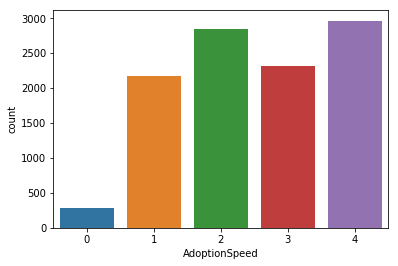

In [65]:
sns.countplot(data.AdoptionSpeed)

Hay un desbalance respecto a la velocidad 0, que representa tan sólo el 13% de la cantidad de datos de otra clase en el mejor de los casos (0 vs 1, 285/2177). Es lógico teniendo en cuenta que la clase 0 representa adopción inmediata, en el mismo día en el que se anota el animal, y las demás clases representan intervalos de tiempo cada vez más largos.


In [74]:
print('Media de adopción diaria para cada clase')
print('ASpeed = 0: ' + str(data.AdoptionSpeed.value_counts()[0]/1))
print('ASpeed = 1: ' + str(data.AdoptionSpeed.value_counts()[1]/7))
print('ASpeed = 2: ' + str(data.AdoptionSpeed.value_counts()[2]/22))
print('ASpeed = 3: ' + str(data.AdoptionSpeed.value_counts()[3]/59))

Media de adopción diaria para cada clase
ASpeed = 0: 285.0
ASpeed = 1: 311.0
ASpeed = 2: 129.36363636363637
ASpeed = 3: 39.152542372881356


### Type: AdoptionSpeed para gatos y perros

El dataset está balanceado a razón de 83% entre perros y gatos (1 y 2)

In [31]:
print(data.Type.value_counts())
print(data.Type.value_counts()[2]/data.Type.value_counts()[1]*100)

1    5770
2    4812
Name: Type, dtype: int64
83.39688041594454


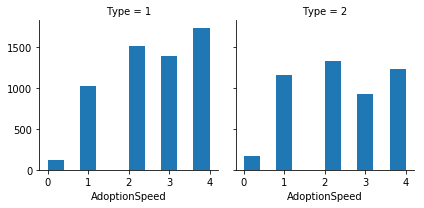

In [32]:
g = sns.FacetGrid(data, col='Type')
g.map(plt.hist, 'AdoptionSpeed')

In [37]:
pd.crosstab(data['Type'], data['AdoptionSpeed'],normalize='index')

AdoptionSpeed,0,1,2,3,4
Type,,,,,
1,0.020971,0.176603,0.262392,0.239515,0.300520
2,0.034081,0.240648,0.276808,0.192851,0.255611


En ambos grupos, perros y gatos, no hay muchos animales adoptados el mismo día en que fueron anotados (AdoptionSpeed = 0). Aunque en general los perros son adoptados en general más lentamente que los gatos. El 19,7% de los perros está acumulado en velocidades de adopción menores o iguales a 1; entre los gatos esa muestra se corresponde con un 27,4% del total.

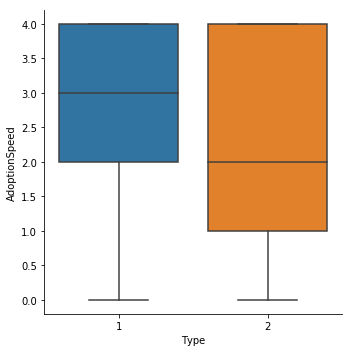

In [54]:
sns.catplot(x='Type', y='AdoptionSpeed',kind='box'
            ,data=data)

In [145]:
print('La velocidad media de adopción para Perros(1) y Gatos(2) es: ')
print(data.groupby('Type').AdoptionSpeed.agg(np.mean))

La velocidad media de adopción para Perros(1) y Gatos(2) es: 
Type
1    2.622010
2    2.395262
Name: AdoptionSpeed, dtype: float64


In [60]:
print('La velocidad media de adopción, sin distinción de animal es: ')
np.mean(data.AdoptionSpeed)

La velocidad media de adopción, sin distinción de animal es: 


2.518900018900019

La media reafirme lo que sugieren los análisis anteriores, en general los gatos se adoptan más rápidamente.

### Age: AdoptionSpeed por edades

In [76]:
data.Age.unique()

array([  3,   4,   1,  12,   2,  78,   6,   8,   0,  10,  14,  24,   5,
        72,  60,   9,  48,  19,  32, 120,  17,  36,  22,   7,  13,  11,
        37,  18,  55,  20,  28,  53,  25,  84,  30,  16,  96,  15,  50,
        56,  54,  23,  29,  27,  44, 144,  51,  65,  34,  21,  41, 135,
        39,  52,  42, 108,  76,  81,  31,  46,  26,  38,  69, 132, 212,
        33,  75,  95,  49,  63,  61, 255,  62,  89,  35,  73, 122, 123,
        87,  64,  47, 156,  66, 112,  77, 180,  82,  86,  92,  40,  57,
       168,  67, 102,  45, 147,  68,  88,  80,  43, 238, 100], dtype=int64)

Se ve un amplio rango de edades. Se supone que están expresadas en meses, aunque se debería contemplar la posibilidad de que algunas estén expresada en años equivocadamente. Se observa un dato anotado de Age=0, lo que resulta dificl de interpretar.  
¿Qué edades predominan?

In [77]:
data.Age.value_counts()

2      2449
1      1607
3      1387
4       799
12      700
       ... 
82        1
66        1
47        1
89        1
255       1
Name: Age, Length: 102, dtype: int64

In [141]:
data.Age.value_counts()[0]

134

Hay 134 animales con edad = 0 ¿?

In [128]:
data.Age.value_counts().cumsum()

2       2449
1       4056
3       5443
4       6242
12      6942
       ...  
82     10578
66     10579
47     10580
89     10581
255    10582
Name: Age, Length: 102, dtype: int64

La mayoría de los animales son jóvenes. La mitad del dataset se encuentra acumulado entre animales de tres meses de edad o menos (la suma acumulada para 3 es 4553).

(Ver fullscreen) En gráficos:

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 <a list of 102 Text xticklabel objects>)

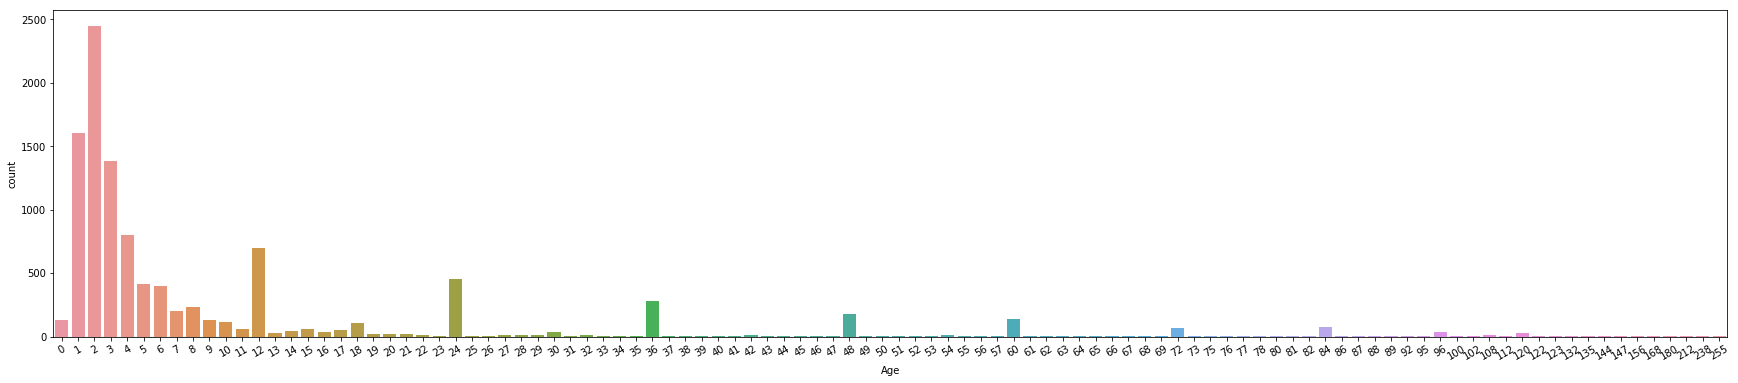

In [126]:
plt.figure(figsize=(30,6))
sns.countplot(data.Age)
plt.xticks(rotation=30)

Particionando en 10 bins

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

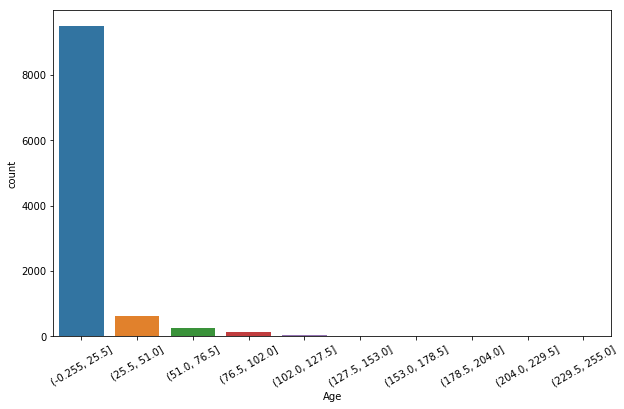

In [127]:
plt.figure(figsize=(10,6))
sns.countplot(pd.cut(data.Age,10))
plt.xticks(rotation=30)

¿Cómo se relaciona la edad con la velocidad de adopción?

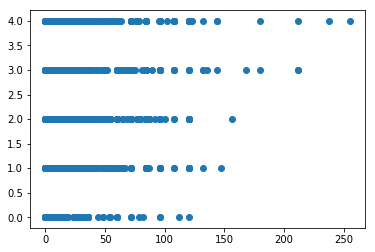

In [144]:
plt.scatter(data=data, x='Age', y='AdoptionSpeed')

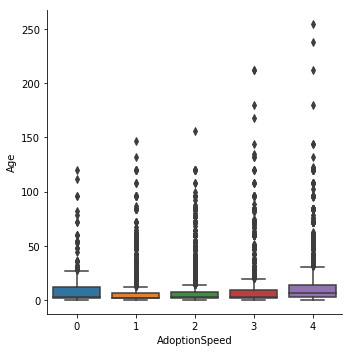

In [165]:
sns.catplot(data=data, x='AdoptionSpeed', y='Age',
           kind='box')

In [147]:
pd.crosstab(pd.cut(data['Age'], 10), data['AdoptionSpeed'], normalize='index')

AdoptionSpeed,0,1,2,3,4
Age,,,,,
"(-0.255, 25.5]",0.026834,0.209092,0.273493,0.219720,0.270862
"(25.5, 51.0]",0.025397,0.179365,0.212698,0.184127,0.398413
"(51.0, 76.5]",0.031008,0.193798,0.263566,0.220930,0.290698
"(76.5, 102.0]",0.030303,0.136364,0.265152,0.265152,0.303030
"(102.0, 127.5]",0.048780,0.170732,0.219512,0.146341,0.414634
"(127.5, 153.0]",0.000000,0.222222,0.000000,0.444444,0.333333
"(153.0, 178.5]",0.000000,0.000000,0.500000,0.500000,0.000000
"(178.5, 204.0]",0.000000,0.000000,0.000000,0.500000,0.500000
"(204.0, 229.5]",0.000000,0.000000,0.000000,0.666667,0.333333


Los animales más viejos no se adoptan en menos de de 8 días. La tabla muestra, dentro de la totalidad de datos para cada grupo de edades, la distribución porcentual de velocidad de adopción. Para observar desde otro punto de vista, se muestra la edad media dentro de cada categoría de AdoptionSpeed.

In [148]:
data.groupby('AdoptionSpeed').Age.agg(np.mean)

AdoptionSpeed
0    10.638596
1     8.701424
2     8.875615
3    10.338095
4    13.566464
Name: Age, dtype: float64

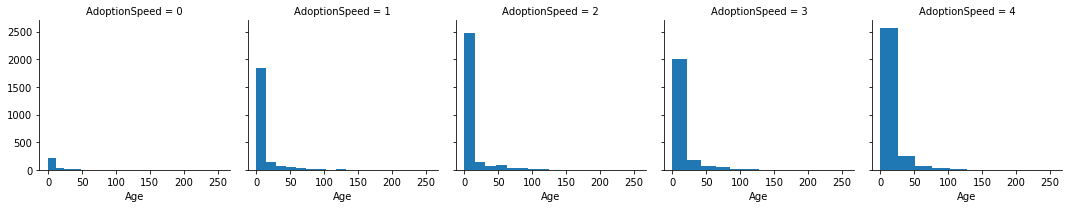

In [182]:
g=sns.FacetGrid(data, col='AdoptionSpeed')
g.map(plt.hist, 'Age')

### Gender and AdoptionSpeed

In [171]:
data.Gender

0        1
1        2
2        1
3        2
4        1
        ..
10577    1
10578    1
10579    3
10580    2
10581    1
Name: Gender, Length: 10582, dtype: int64

In [173]:
print(data.Gender.unique())

[1 2 3]


In [174]:
data.Gender.value_counts()

2    5104
1    3908
3    1570
Name: Gender, dtype: int64

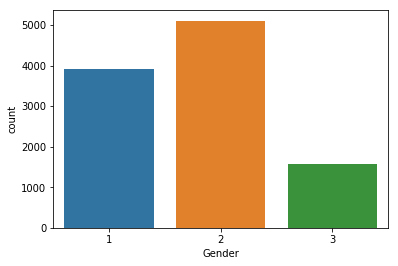

In [192]:
sns.countplot(data['Gender'])

In [196]:
print('Relación aniamales hembras/machos:'+'\n' +str(5104/3908))
print('Relación aniamales hembras/no informados:'+'\n' +str(5104/1570))

Relación aniamales hembras/machos:
1.3060388945752304
Relación aniamales hembras/no informados:
3.250955414012739


La mayoría de datos corresponden a animales hembras en proporción razonablemente equilibrada con los animales macho pero con más de tres veces la cantidad de datos con respecto al grupo no informado (3).  
A continuación, según especie.

In [181]:
data.groupby(['Type']).Gender.value_counts()

Type  Gender
1     2         3000
      1         2137
      3          633
2     2         2104
      1         1771
      3          937
Name: Gender, dtype: int64

C:\Users\santi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


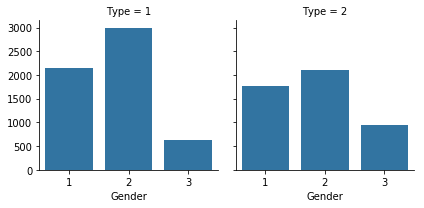

In [187]:
g=sns.FacetGrid(data,col='Type')
g.map(sns.countplot,'Gender')

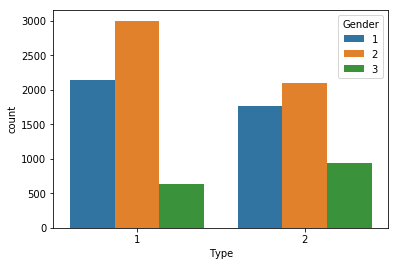

In [197]:
sns.countplot(data['Type'], hue=data['Gender'])

Las proporciones se mantienen.  
¿Existe alguna relación obvia con AdoptionSpeed?

Cantidad de animales adoptados en cada categoría de velocidad, según género. Hay aproximadamente 500 animales hembras sin adoptar, que machos sin adoptar.

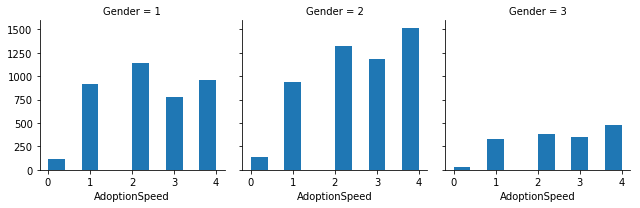

In [205]:
g = sns.FacetGrid(data=data, col='Gender')
g.map(plt.hist, 'AdoptionSpeed')

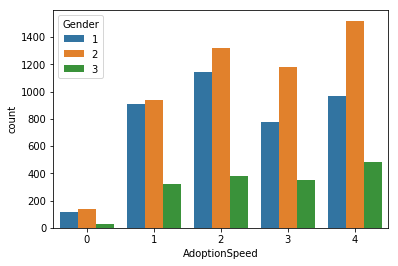

In [221]:
sns.countplot(data['AdoptionSpeed'], hue=data['Gender'])

Velocidad de adopción media por género

In [201]:
data.groupby(['Gender']).AdoptionSpeed.agg(np.mean)

Gender
1    2.398925
2    2.588362
3    2.591720
Name: AdoptionSpeed, dtype: float64

Los animales macho en general son adoptados más rápido.

Velocidad promedio de adopción según género, para cada especie por separado

C:\Users\santi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\santi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


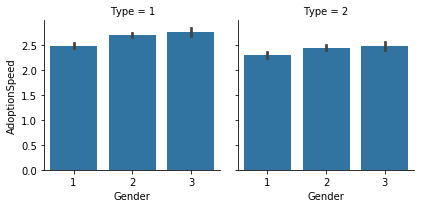

In [206]:
g = sns.FacetGrid(data, col='Type')
g.map(sns.barplot, 'Gender','AdoptionSpeed')

En ambas especies, los animales macho tienen una demora menor para ser adoptados, en promedio

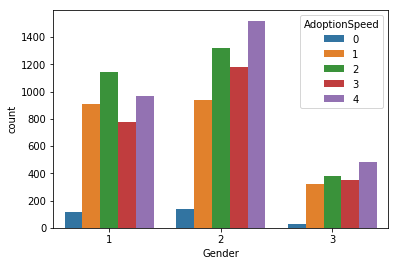

In [212]:
sns.countplot(data['Gender'],hue=data['AdoptionSpeed'])

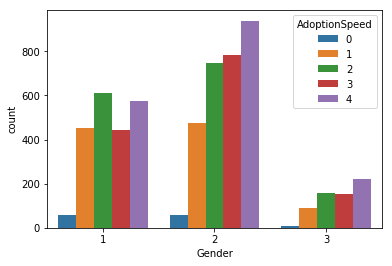

In [213]:
sns.countplot(data[data['Type']==1].Gender,hue=data['AdoptionSpeed'])

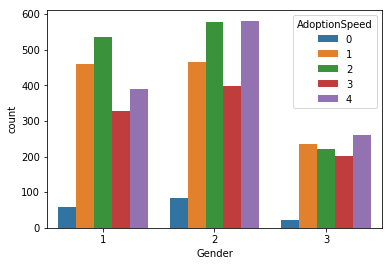

In [214]:
sns.countplot(data[data['Type']==2].Gender,hue=data['AdoptionSpeed'])

In [ ]:
f = plt.figure(figsize=(13, 13))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)